In [1]:
import os
import PIL
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt 

from tqdm.notebook  import tqdm
from torchvision import transforms
from torchvision.models import vgg19
from torchvision.utils import make_grid, save_image
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp


import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
class Resnet_re(nn.Module):
    
    def __init__(self):
        super(Resnet_re, self).__init__()
        self.model   = models.resnet50(pretrained=True)
        self.conv1   = self.model.conv1 
        self.bn1     = self.model.bn1 
        self.relu    = self.model.relu 
        self.maxpool = self.model.maxpool 
        self.layer1  = self.model.layer1 
        self.layer2  = self.model.layer2
        self.layer3  = self.model.layer3
        self.layer4  = self.model.layer4
        self.avgpool = self.model.avgpool        
        self.linear  =  nn.Sequential(
                        nn.Linear(2048, 512),
                        nn.Dropout(0.2),
                        nn.ReLU(inplace=True),
                        nn.Linear(512,1))

    def forward(self, x):
                        
        for param in self.parameters():
            param.requires_grad = True
        
        for param in self.linear.parameters():
            param.requires_grad = True
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(1,-1)
        x = self.linear(x)
        
        return x
    
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        # get the pretrained VGG19 network
        self.vgg = vgg19(pretrained=True)
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier[:5]
        # change the number of classes 
        self.classifier2 = nn.Linear(4096, 512)
        self.classifier3 = nn.Linear(512, 1)
        
    def forward(self, x):
        
        for param in self.parameters():
            param.requires_grad = True
        
        for param in self.classifier.parameters():
            param.requires_grad = True
            
        for param in self.classifier2.parameters():
            param.requires_grad = True
            
        for param in self.classifier3.parameters():
            param.requires_grad = True
            
        x = self.features_conv(x)
        x = self.max_pool(x)
        x = x.view((1,-1))
        x = self.classifier(x)
        x = self.classifier2(x)
        x = self.classifier3(x)
        return x

In [114]:
Resnet = Resnet_re()
Resnet.load_state_dict(torch.load('model/resnet/best_model361.pt') )
Resnet.eval()
Resnet.to(device)

vgg = VGG()
vgg.load_state_dict(torch.load('model/vgg/best_model619.pt') )
vgg.eval()
vgg.to(device)

Resnet_uf = Resnet_re()
Resnet_uf.load_state_dict(torch.load('model/resnet/best_model_unfreeze198.pt') )
Resnet_uf.eval()
Resnet_uf.to(device)

vgg_uf = VGG()
vgg_uf.load_state_dict(torch.load('model/vgg/best_model_unfreeze114.pt') )
vgg_uf.eval()
vgg_uf.to(device)

def show(path):
    img_dir = '../'
    img_name = path
    img_path = os.path.join(img_dir, img_name)

    pil_img = PIL.Image.open(img_path)

    torch_img = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])(pil_img).to(device)
    normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]
    
    print('Resnet score :',float(Resnet(normed_torch_img)))    
    images = []    
#     layer = [model.layer1,model.layer2,model.layer3,model.layer4]
#     for L in tqdm(layer):
    gradcam = GradCAMpp(Resnet,Resnet.layer4)

    mask, _ = gradcam(normed_torch_img.to(device))
    heatmap, result = visualize_cam(mask, torch_img)

    images.extend([torch_img.cpu(), heatmap, result])
    
    print('vgg score :',float(vgg(normed_torch_img)))    
    
    gradcam = GradCAMpp(vgg,vgg.features_conv)

    mask, _ = gradcam(normed_torch_img.to(device))
    heatmap, result = visualize_cam(mask, torch_img)

    images.extend([torch_img.cpu(), heatmap, result])

    print('Resnet_uf score :',float(Resnet_uf(normed_torch_img)))    
    gradcam = GradCAMpp(Resnet,Resnet.layer4)

    mask, _ = gradcam(normed_torch_img.to(device))
    heatmap, result = visualize_cam(mask, torch_img)

    images.extend([torch_img.cpu(), heatmap, result])
    
    print('vgg_uf score :',float(vgg_uf(normed_torch_img)))    
    
    gradcam = GradCAMpp(vgg,vgg.features_conv)

    mask, _ = gradcam(normed_torch_img.to(device))
    heatmap, result = visualize_cam(mask, torch_img)

    images.extend([torch_img.cpu(), heatmap, result])
    
    grid_image = make_grid(images, nrow=3)
    return transforms.ToPILImage()(grid_image)

In [115]:
# dic = torch.load('loss_resnet.pt')

In [116]:
# plt.figure(figsize=(10,5),dpi=80)
# plt.plot(dic['train_loss'])
# plt.plot(dic['valid_loss'])
# plt.title('loss')
# plt.legend(['train_loss','valid_loss'])

Resnet score : 0.22640539705753326
vgg score : 0.19967344403266907
Resnet_uf score : 0.19637073576450348
vgg_uf score : 0.1990571916103363


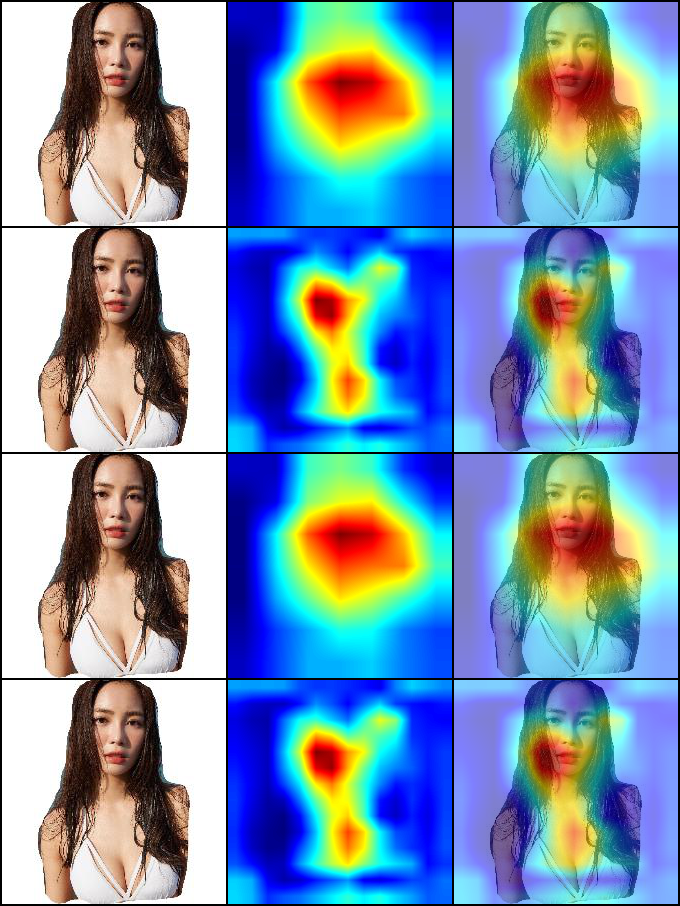

In [117]:
show('beauty/beauty_re/4142_0_100.jpg')

Resnet score : 0.19249410927295685
vgg score : 0.19956019520759583
Resnet_uf score : 0.19006487727165222
vgg_uf score : 0.19391849637031555


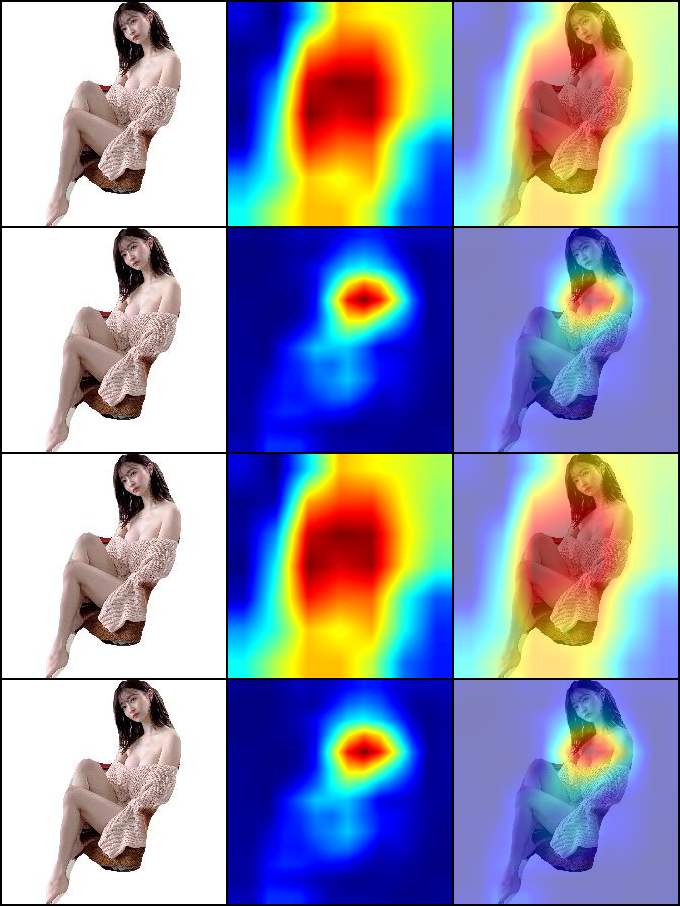

In [118]:
show('beauty/beauty_re/1259_0_72.jpg')

In [ ]:
show('beauty/beauty_re/5944_0_81.jpg')

Resnet score : 0.19607850909233093
vgg score : 0.17104598879814148
Resnet_uf score : 0.17782677710056305
vgg_uf score : 0.16490033268928528


In [ ]:
show('beauty/beauty_re/4006_0_100.jpg')

In [ ]:
show('beauty/beauty_re/4298_0_100.jpg')

In [ ]:
show('beauty/beauty_re/3595_0_5.jpg')